### What is the research question? 
Can machine learning models trained on textual data from international organizations, including financial experts' reports, economic, and trade-related news predicts global economic performance, such as financial crises or periods of slow economic growth?
### What motivates you to do this research? 
Real-time detection of economic activity can be useful for policymakers engaged in implementing macroprudential policies and managing crises, as well as in shaping monetary, fiscal, or trade policies. For example, they can better inform decisions about the initiation and duration of interventions like the counter-cyclical capital buffer (CCyB), which are designed to stabilize financial markets and prevent economic downturns.



### Exploratory data analysis 

There are 5 parts in this notebook. 

- **Part-0: Raw data Import and Merging**
    > Merge Economic Indicator (World GDP) with the web-scraped text data <br>
    > create new features <br>
    
- **Part-1: Data cleaning**
    > organize attributes into appripriate data types (e.g., numerical, categorical, datatime, text) <br>
    > missing value and outlier detection <br>
    
- **Part-2: Data overview**
    > check the #samples, #attributes <br>
    > attribute types <br>
    
- **Part-3: Data transformation**
    > normalize numerical data (gdp)<br>
    > transform text data: tokenization, stemming, and lemmatization <br>
    
- **Part-4: Feature engineering**
    > encode categorical data <br>
    > convert DataTime data <br>
    > text feature representation <br>

- **Part-5: Additional analysis**
    > Visualization <br>
    > colinearty check <br>

#### EDA checklist
1. Understand the Dataset
 Review dataset dimensions (rows->#samples, columns->#features)
 Identify feature types (numerical, categorical, etc)
2. Data Cleaning
 Check and handling missing values
 Detect outliers (categorical, numerical)
 Handling outliers (keep, remove, adjust)
 Check and handling duplicates
3. Data Transformation and feature engineering
 Group features by types
 Numerical data: normalization/standardization
 Categorical data: one-hot encoding, ordinal encoding
 Text data: tokenization, stemming/lemmatization, countvectorizer, tfidfvectorizer, embedding
 Image/video data
4. Statistical summary
 Basic statistics (mean, median, mode)
 Visualization (scatter plot, histograms, box plot, heatmap, etc)
 Check data distribution and skewness
5. Correlation analysis
 Check relationships between variables

In [1]:
import csv
import pandas as pd
import spacy
import re
import geograpy
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow
from dateutil import parser
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

### Part-0: Raw data Import and Merging

In [2]:

df_gdp = pd.read_csv('C:/Users/Victoria/OneDrive/文档/Dropbox/Machine Learning Python/Project/gdp.csv')

# Filter the DataFrame to keep only the row where 'Country Name' is 'World'
df_gdp = df_gdp[df_gdp['Country Name'] == 'World']

# Drop the unwanted columns and reassign the DataFrame
df_gdp = df_gdp.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code'])

# Now use melt() to reshape the DataFrame
df_gdp = df_gdp.melt(id_vars=['Country Name'],
                     var_name='Year',
                     value_name='gdp')
df_gdp = df_gdp.drop(columns=['Country Name'])
# Check the first few rows of the reshaped DataFrame
df_gdp.head()

,Year,gdp
0,1960,NaN
1,1961,3.772924
2,1962,5.375360
3,1963,5.194927
4,1964,6.564476


In [3]:
# Load the raw data CSV file into a DataFrame
df_text = pd.read_csv('text_combine.csv')

# Count the number of duplicates
duplicate_count = df_text.duplicated(subset='URL').sum()
print(f"Number of duplicate entries based on URLs: {duplicate_count}")

# Drop duplicates based on the 'url' column
df_text = df_text.drop_duplicates(subset='URL')



Number of duplicate entries based on URLs: 26


In [4]:

# Drop the 'url' column from the DataFrame in-place
df_text.drop(columns=['URL'], inplace=True)

# Get an overview of the top-n rows/samples
print(df_text.head())

                                               Title              Date  \
0  2024 Report of the Committee for Development P...      9 April 2024   
1  World Economic Situation and Prospects: April ...      1 April 2024   
2  World Economic Situation and Prospects: March ...  29 February 2024   
3  Innovation ecosystems: making intellectual pro...  19 February 2024   
4  A globally just transition: Perspectives from ...   5 February 2024   

                                         Description  
0  ADVANCE UNEDITED VERSION of the Report on the ...  
1  Given the strong interactions between domestic...  
2  Regional integration in West African economies...  
3  CDP members will address intellectual property...  
4  This Policy Note compiles perspectives from th...  


In [5]:
def extract_year(date_str):
    try:
        # Parse the date string to datetime
        date = parser.parse(date_str)
        # Format the datetime object to year format 'YYYY'
        return date.strftime('%Y')
    except ValueError:
        return "Invalid Date"  # In case of parsing errors

# Apply the function to the Date column
df_text['Year'] = df_text['Date'].apply(extract_year)

In [6]:
df_gdp['Year'] = df_gdp['Year'].astype(str)
df_text['Year'] = df_text['Year'].astype(str)
df = pd.merge(df_gdp, df_text, on='Year', how='right')
df = df.drop('Date', axis=1)

In [7]:
# check the shape of the data frame: row: #samples (short for number of samples), column: #attributes (short for number of attributes)
df.shape

(6979, 4)

In [8]:
df.head()

,Year,gdp,Title,Description
0,2024,NaN,2024 Report of the Committee for Development P...,ADVANCE UNEDITED VERSION of the Report on the ...
1,2024,NaN,World Economic Situation and Prospects: April ...,Given the strong interactions between domestic...
2,2024,NaN,World Economic Situation and Prospects: March ...,Regional integration in West African economies...
3,2024,NaN,Innovation ecosystems: making intellectual pro...,CDP members will address intellectual property...
4,2024,NaN,A globally just transition: Perspectives from ...,This Policy Note compiles perspectives from th...


### Part-1: Data cleaning

#### check missing values

In [9]:
null_sum = df.isnull().sum()
null_sum

Year             0
gdp            345
Title            0
Description     12
dtype: int64

In [10]:
# Drop columns that missing values 
df = df.dropna()

In [11]:
count_date = df['Year'].value_counts()
# Print the unique country names found
print(count_date)

Year
2017    629
2016    619
2015    542
2012    441
2011    415
2013    412
2010    410
2008    389
2009    382
2014    371
2007    354
2022    309
2006    302
2021    290
2020    241
2019    216
2018    209
2005     42
2004     19
2003     15
2002      8
2001      8
2000      1
Name: count, dtype: int64


In [12]:
#remove those years with less than 50 sample
year_cts = df['Year'].value_counts()
year_to_remove = year_cts[ year_cts < 50].keys()
year_to_remove

Index(['2005', '2004', '2003', '2002', '2001', '2000'], dtype='object', name='Year')

In [13]:
print("Data size before dropping minority Years:", df.shape)
df.drop(df[df['Year'].isin(year_to_remove)].index, inplace=True)
print("Data size after dropping minority categories:", df.shape)

Data size before dropping minority Years: (6624, 4)
Data size after dropping minority categories: (6531, 4)


### Part-2: Data overview

In [14]:
df.dtypes 

Year            object
gdp            float64
Title           object
Description     object
dtype: object

In [15]:

# Convert 'Description' and 'Title' to string
df['Description'] = df['Description'].astype(str)
df['Title'] = df['Title'].astype(str)

# Convert 'Year' and 'Date' to datetime
# For 'Year', assuming it's just a year and you want it as the first day of that year
df['Year'] = pd.to_datetime(df['Year'], format='%Y', errors='coerce')

# Check the DataFrame dtypes to confirm changes
print(df.dtypes)

Year           datetime64[ns]
gdp                   float64
Title                  object
Description            object
dtype: object


In [16]:
df.head()

,Year,gdp,Title,Description
47,2022-01-01,3.089379,CDP at the Ministerial Conference of the Group...,CDP Vice Chair speaking at the roundtable disc...
48,2022-01-01,3.089379,World Economic Situation and Prospects: Decemb...,"Governments, households, and firms across Euro..."
49,2022-01-01,3.089379,Briefing to ECOSOC on the work of the CDP on LDCs,CDP briefing to ECOSOC members on its work on ...
50,2022-01-01,3.089379,UN DESA Policy Brief No. 142: Old-age poverty ...,An agenda on gender equality aimed at reducing...
51,2022-01-01,3.089379,UN DESA Policy Brief No. 141: A just green tra...,A globally just transition requires internatio...


In [17]:
df.shape

(6531, 4)

### Part-3: Data transformation

#### Normalize numerical data

In [18]:
scaler = StandardScaler()
gdp_array = df['gdp'].values.reshape(-1, 1)
# Fit and transform the 'gdp' column
gdp_scaled = scaler.fit_transform(gdp_array)
# Add the scaled GDP values as a new column in the DataFrame
df['gdp_normal'] = gdp_scaled

#### Convert numerical GDP data into a categorical variable

In [19]:
# Creating the 'gdp_grow_dummy' column
df['gdp_grow_dummy'] = np.where(df['gdp'] < 0, 0, 1)

# Display the updated DataFrame
print(df[['gdp', 'gdp_grow_dummy']])

           gdp  gdp_grow_dummy
47    3.089379               1
48    3.089379               1
49    3.089379               1
50    3.089379               1
51    3.089379               1
...        ...             ...
6957  2.590785               1
6958  2.590785               1
6959  2.590785               1
6962 -3.057810               0
6963 -3.057810               0

[6531 rows x 2 columns]


#### Create a new variable that indicates the GDP growth last year

In [20]:
# Calculate the average GDP per year and create a lagged GDP column
df_aggregated = df.groupby('Year')['gdp'].mean().reset_index()
df_aggregated['lag_gdp'] = df_aggregated['gdp'].shift(1)

# Merge the lagged GDP data back to the original DataFrame
df = df.merge(df_aggregated[['Year', 'lag_gdp']], on='Year', how='left')


#### Text transformation: text data tokenization, stemming/lemmatization

In [21]:
import nltk
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

In [22]:
sample_text = df.iloc[4888]['Description']
sample_text

'This paper evaluates and addresses Malaysia’s compliance with the Core Principles for Effective Deposit Insurance Systems (Core Principles), and reviews relevant laws, regulations and regulatory and supervisory practices related to conventional banking sector, and the operations of Perbadanan Insurans Deposit Malaysia (PIDM). Though several weaknesses in the legal framework have been noted in this assessment, there has been no experience with bank failures in Malaysia since PIDM’s establishment in 2005. The paper also covers Islamic deposits, which manage a separate Islamic Deposit Insurance Fund (IDIF).'

In [23]:
description_text = df['Description']

In [24]:
# Define a function that applies sentence tokenization to a given text
def tokenize_description(text):
    try:
        # Use NLTK's sentence tokenizer
        return nltk.sent_tokenize(text)
    except TypeError:
        return []  # Return an empty list if text is not a string

# Apply this function to each element in the 'Description' column
df['Tokenized_Description'] = df['Description'].apply(tokenize_description)

In [25]:
print(nltk.word_tokenize(sample_text))

['This', 'paper', 'evaluates', 'and', 'addresses', 'Malaysia', '’', 's', 'compliance', 'with', 'the', 'Core', 'Principles', 'for', 'Effective', 'Deposit', 'Insurance', 'Systems', '(', 'Core', 'Principles', ')', ',', 'and', 'reviews', 'relevant', 'laws', ',', 'regulations', 'and', 'regulatory', 'and', 'supervisory', 'practices', 'related', 'to', 'conventional', 'banking', 'sector', ',', 'and', 'the', 'operations', 'of', 'Perbadanan', 'Insurans', 'Deposit', 'Malaysia', '(', 'PIDM', ')', '.', 'Though', 'several', 'weaknesses', 'in', 'the', 'legal', 'framework', 'have', 'been', 'noted', 'in', 'this', 'assessment', ',', 'there', 'has', 'been', 'no', 'experience', 'with', 'bank', 'failures', 'in', 'Malaysia', 'since', 'PIDM', '’', 's', 'establishment', 'in', '2005', '.', 'The', 'paper', 'also', 'covers', 'Islamic', 'deposits', ',', 'which', 'manage', 'a', 'separate', 'Islamic', 'Deposit', 'Insurance', 'Fund', '(', 'IDIF', ')', '.']


#### Stemming: apply rule-based method (e.g., cut the suffixes in words) to find the root of the word

#### lemmatization: use lexical based knowledge to get the base forms of words

In [26]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize

# Define the stemmer and lemmatizer
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Define a function that applies word tokenization, stemming, and lemmatization to a given text
def stem_and_lemmatize(text):
    try:
        # Use NLTK's word tokenizer
        words = nltk.word_tokenize(text)
        # Apply stemming and lemmatization to each word
        stemmed_and_lemmatized_words = [lemmatizer.lemmatize(ps.stem(word)) for word in words]
        # Join words back into a single string (if you want to return a string instead of list)
        return ' '.join(stemmed_and_lemmatized_words)
    except TypeError:
        return ''  # Return an empty string if text is not a string

# Assume 'df' is your DataFrame and it contains a 'Description' column
# Apply this function to each element in the 'Description' column
df['Stem_Lemm_Description'] = df['Description'].apply(stem_and_lemmatize)


In [27]:
print(stem_and_lemmatize(sample_text))

thi paper evalu and address malaysia ’ s complianc with the core principl for effect deposit insur system ( core principl ) , and review relev law , regul and regulatori and supervisori practic relat to convent bank sector , and the oper of perbadanan insuran deposit malaysia ( pidm ) . though sever weak in the legal framework have been note in thi ass , there ha been no experi with bank failur in malaysia sinc pidm ’ s establish in 2005 . the paper also cover islam deposit , which manag a separ islam deposit insur fund ( idif ) .


#### Combine tokenization and lemmatization together

In [28]:
# Function to process text: tokenize words, then stem and lemmatize
def process_text(text):
    try:
        # Word tokenization
        words = word_tokenize(text)
        # Apply stemming and lemmatization to each word
        processed_words = [lemmatizer.lemmatize(ps.stem(word)) for word in words]
        return processed_words
    except TypeError:
        return []  # Return an empty list if text is not a string


df['Processed_Words'] = df['Description'].apply(process_text)


In [29]:
print(process_text(sample_text))

['thi', 'paper', 'evalu', 'and', 'address', 'malaysia', '’', 's', 'complianc', 'with', 'the', 'core', 'principl', 'for', 'effect', 'deposit', 'insur', 'system', '(', 'core', 'principl', ')', ',', 'and', 'review', 'relev', 'law', ',', 'regul', 'and', 'regulatori', 'and', 'supervisori', 'practic', 'relat', 'to', 'convent', 'bank', 'sector', ',', 'and', 'the', 'oper', 'of', 'perbadanan', 'insuran', 'deposit', 'malaysia', '(', 'pidm', ')', '.', 'though', 'sever', 'weak', 'in', 'the', 'legal', 'framework', 'have', 'been', 'note', 'in', 'thi', 'ass', ',', 'there', 'ha', 'been', 'no', 'experi', 'with', 'bank', 'failur', 'in', 'malaysia', 'sinc', 'pidm', '’', 's', 'establish', 'in', '2005', '.', 'the', 'paper', 'also', 'cover', 'islam', 'deposit', ',', 'which', 'manag', 'a', 'separ', 'islam', 'deposit', 'insur', 'fund', '(', 'idif', ')', '.']


### Part-4: Feature engineering

#### Count Vectorization

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=5, max_df=0.8,ngram_range=(1,1),binary=False,stop_words='english')
# Join the words back into strings
df['Joined_Words'] = df['Processed_Words'].apply(' '.join)
# Fit and transform the descriptions
X = vectorizer.fit_transform(df['Joined_Words'])

In [31]:
# check the feature matrix of the vectorized corpus
X.shape

(6531, 3191)

In [32]:
import matplotlib.pyplot as plt

In [33]:
# check the extracted features during the vectorization
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['00', '000', '04', ..., 'zhang', 'zimbabw', 'zone'], dtype=object)

In [34]:
# Find out the top-10 most frequent features 
def get_topn_features(X, feature_names, topn=10):
    """
    Inputs:
        X: feature matrix
        feature_names: extracted features during vectorization
        topn: the number of most frequent features to return
    Outputs:
        topn most frequent features and their frequency
    """
    feature_ct = np.asarray(np.sum(X, axis=0)).reshape(-1)

    feature_freq = []
    
    for i in np.argsort(feature_ct)[::-1][:topn]:
        feature_freq.append({'feature':feature_names[i], 'frequency':feature_ct[i]})
    
    return pd.DataFrame(feature_freq)

In [35]:
get_topn_features(X, feature_names, topn=10)

,feature,frequency
0,wto,3383
1,trade,2932
2,growth,2487
3,ha,2466
4,develop,2259
5,polici,2087
6,thi,1909
7,financi,1864
8,econom,1783
9,countri,1467


From the top-10 most frequent features, we observe that most texts contain trade, growth, develop, finance, economy, etc.
However, it is unclear why "ha""this"  appears to be a frequent word. We need to find out documents that contain "ha" and explore the specific reason.

In [36]:
# find the index of "wto" from the lemmatized corpus
np.where(feature_names == 'wto')
# find "wto" from the lemmatized corpus
np.array(df['Joined_Words'])[np.where(X[:, 80].toarray() > 0)[0]][:1] # only select 1 sample for visualization purpose

array(['the report of the committe for develop polici ( e/2017/33 , supplement no . 13 ) on it 19th plenari session held from 20-24 march 2017 is now avail in all six offici languag . the report address the six theme discus by the cdp dure the ...'],
      dtype=object)

In [37]:
# find "ha" from the raw df before tokenization and lemmatization
df['Description'].values[np.where(X[:, 80].toarray() > 0)[0]][:1] # only select 1 sample for visualization purpose

array(['The Report of the Committee for Development Policy (E/2017/33, Supplement No. 13) on its 19th plenary session held from 20-24 March 2017 is now available in all six official languages. The report addresses the six themes discussed by the CDP during the ...'],
      dtype=object)

In [38]:
lemmatizer.lemmatize('wto')

'wto'

According to our common sense, "wto" doesn't provide a deeper understanding of economic information. So we can process it as a stop-word and remove it during the vectorization process. Similar steps are applied to "ha" and "thi", which are words from has and this/these/

In [39]:
description = df.iloc[:]['Description']
description_lem = []
for text in description:
    word_list = nltk.word_tokenize(text)
    word_lem = [lemmatizer.lemmatize(tok) for tok in word_list]
    description_lem.append(' '.join(word_lem))


In [40]:
# Existing English stop words
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Adding custom stop words to the existing set of English stop words
custom_stop_words = set(ENGLISH_STOP_WORDS).union({'gdp','2017','2016','unit','2015','2014','highlight','includ','agreement','19','organ','financ','domest','trade','larg','structur','fund','pascal','lami','implement','committe','region','recent','medium','octob','work','ass','outlook','framework','gpd','project','polici','state','new','consult','financi','expect','negoti','develop','product','economi','wa','govern','world','bank','review','extern','intern','said','discus','ha','thi','wto','countri','percent','report','gener','growth','director','global','author','member','econom','articl','iv','measure','year','market','public','sector','measur','term','meet'})
custom_stop_words = list(custom_stop_words)
vectorizer = CountVectorizer(min_df=5, max_df=0.8, ngram_range=(1,1), binary=False, stop_words=custom_stop_words)
# Join the words back into strings
df['Joined_Words'] = df['Processed_Words'].apply(' '.join)

# Fit and transform the descriptions with the updated vectorizer
X = vectorizer.fit_transform(df['Joined_Words'])

# Check the feature matrix of the vectorized corpus
print("Shape of the feature matrix:", X.shape)

# Check the extracted features during the vectorization
feature_names = vectorizer.get_feature_names_out()
print("Extracted feature names:", feature_names)

# Find out the top-10 most frequent features
def get_topn_features(X, feature_names, topn=30):
    """
    Inputs:
        X: feature matrix
        feature_names: extracted features during vectorization
        topn: the number of most frequent features to return
    Outputs:
        topn most frequent features and their frequency
    """
    feature_ct = np.asarray(np.sum(X, axis=0)).reshape(-1)
    feature_freq = []
    for i in np.argsort(feature_ct)[::-1][:topn]:
        feature_freq.append({'feature': feature_names[i], 'frequency': feature_ct[i]})
    return pd.DataFrame(feature_freq)

# Display the top-20 most frequent features
top_features = get_topn_features(X, feature_names, topn=30)
print(top_features)


Shape of the feature matrix: (6531, 3120)
Extracted feature names: ['00' '000' '04' ... 'zhang' 'zimbabw' 'zone']
        feature  frequency
0        fiscal       1303
1        remain       1089
2          risk       1060
3       support       1014
4       continu        889
5        reform        817
6        import        794
7          need        780
8          debt        765
9        improv        737
10      increas        688
11       strong        673
12      sustain        672
13         issu        653
14        price        642
15        crisi        629
16         help        626
17       inflat        614
18         high        607
19   strengthen        590
20       stabil        584
21     recoveri        582
22     challeng        572
23       invest        561
24       pandem        525
25       disput        523
26       export        502
27        activ        475
28  macroeconom        473
29       access        471


#### Encoding top features into binary variable columns

In [41]:
top_features_list = top_features['feature'].tolist()

# Create a vectorizer with only the top features
top_features_vectorizer = CountVectorizer(vocabulary=top_features_list, binary=True)

# Transform the 'Joined_Words' to get a matrix of the top features
top_features_matrix = top_features_vectorizer.fit_transform(df['Joined_Words'])

# Convert this matrix into a DataFrame
top_features_df = pd.DataFrame(top_features_matrix.toarray(), columns=top_features_vectorizer.get_feature_names_out())

# Concatenate this new DataFrame with the original DataFrame
df = pd.concat([df, top_features_df], axis=1)

In [42]:
df.head()

,Year,gdp,Title,Description,gdp_normal,gdp_grow_dummy,lag_gdp,Tokenized_Description,Stem_Lemm_Description,Processed_Words,...,stabil,recoveri,challeng,invest,pandem,disput,export,activ,macroeconom,access
0,2022-01-01,3.089379,CDP at the Ministerial Conference of the Group...,CDP Vice Chair speaking at the roundtable disc...,0.125297,1,6.228594,[CDP Vice Chair speaking at the roundtable dis...,cdp vice chair speak at the roundtabl discus o...,"[cdp, vice, chair, speak, at, the, roundtabl, ...",...,0,0,0,1,0,0,0,0,0,1
1,2022-01-01,3.089379,World Economic Situation and Prospects: Decemb...,"Governments, households, and firms across Euro...",0.125297,1,6.228594,"[Governments, households, and firms across Eur...","govern , household , and firm across europ are...","[govern, ,, household, ,, and, firm, across, e...",...,0,0,0,0,0,0,0,0,0,0
2,2022-01-01,3.089379,Briefing to ECOSOC on the work of the CDP on LDCs,CDP briefing to ECOSOC members on its work on ...,0.125297,1,6.228594,[CDP briefing to ECOSOC members on its work on...,cdp brief to ecosoc member on it work on ldc r...,"[cdp, brief, to, ecosoc, member, on, it, work,...",...,0,0,0,0,0,0,0,0,0,0
3,2022-01-01,3.089379,UN DESA Policy Brief No. 142: Old-age poverty ...,An agenda on gender equality aimed at reducing...,0.125297,1,6.228594,[An agenda on gender equality aimed at reducin...,an agenda on gender equal aim at reduc woman ’...,"[an, agenda, on, gender, equal, aim, at, reduc...",...,0,0,0,0,0,0,0,0,0,0
4,2022-01-01,3.089379,UN DESA Policy Brief No. 141: A just green tra...,A globally just transition requires internatio...,0.125297,1,6.228594,[A globally just transition requires internati...,a global just transit requir intern support fo...,"[a, global, just, transit, requir, intern, sup...",...,0,0,0,0,0,0,0,0,0,0


In [44]:
df.shape

(6531, 41)

In [45]:
df.to_csv('data_EDA.csv', index=False)

#### TfidfVectorizer

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 3), #determines how many words will be treated as a text representation
                             max_df=0.5, #how many percent a word appear[if word appear 80%, drop it]
                             min_df=2,
                             smooth_idf=False)

In [47]:
X = vectorizer.fit_transform(description_text)
X.shape

(6531, 85322)

In [48]:
vectorizer.get_feature_names_out()
pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

,00,00 am,00 to,000,000 000,000 000 chf,000 about,000 about chf,000 about chf1,000 approximately,...,zimbabwe,zimbabwe experienced,zone,zone of,zones,zones and,zones and tax,zorica,zorica marić,zorica marić djordjević
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6526,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6527,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6528,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6529,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### **Part-5: Additional analysis**

#### Correlations among multiple columns:
- as a way to measure colinearty
- visualize the correlation matrix as a heatmap
-  A negative correlation between GDP growth and crisis, debt, risk observed in the heatmap suggests that as crisis/debt/risk occurrences increase, GDP growth tends to decrease.
-  A positive correlation between GDP growth and recovery observed in the heatmap suggests that when signs of economic recovery are present, there is often an associated increase in GDP growth. 
-  A negative correlation between lag_gdp (previous year's GDP growth) and current GDP (GDP growth) could suggest periods of decline following a rise, or vice versa.
-  The variable disput showing a negative correlation with most variables, except for import, could indicate that disputes might have an adverse effect on various economic factors. However, imports could potentially increase if the disputes lead to a need for more goods from outside sources, or perhaps the disputes refer to trade disputes specifically, which might directly involve import activities.
-  It's logical to see a positive correlation between price and inflation. In economic terms, when prices rise, it generally signals an increase in inflationary trends.

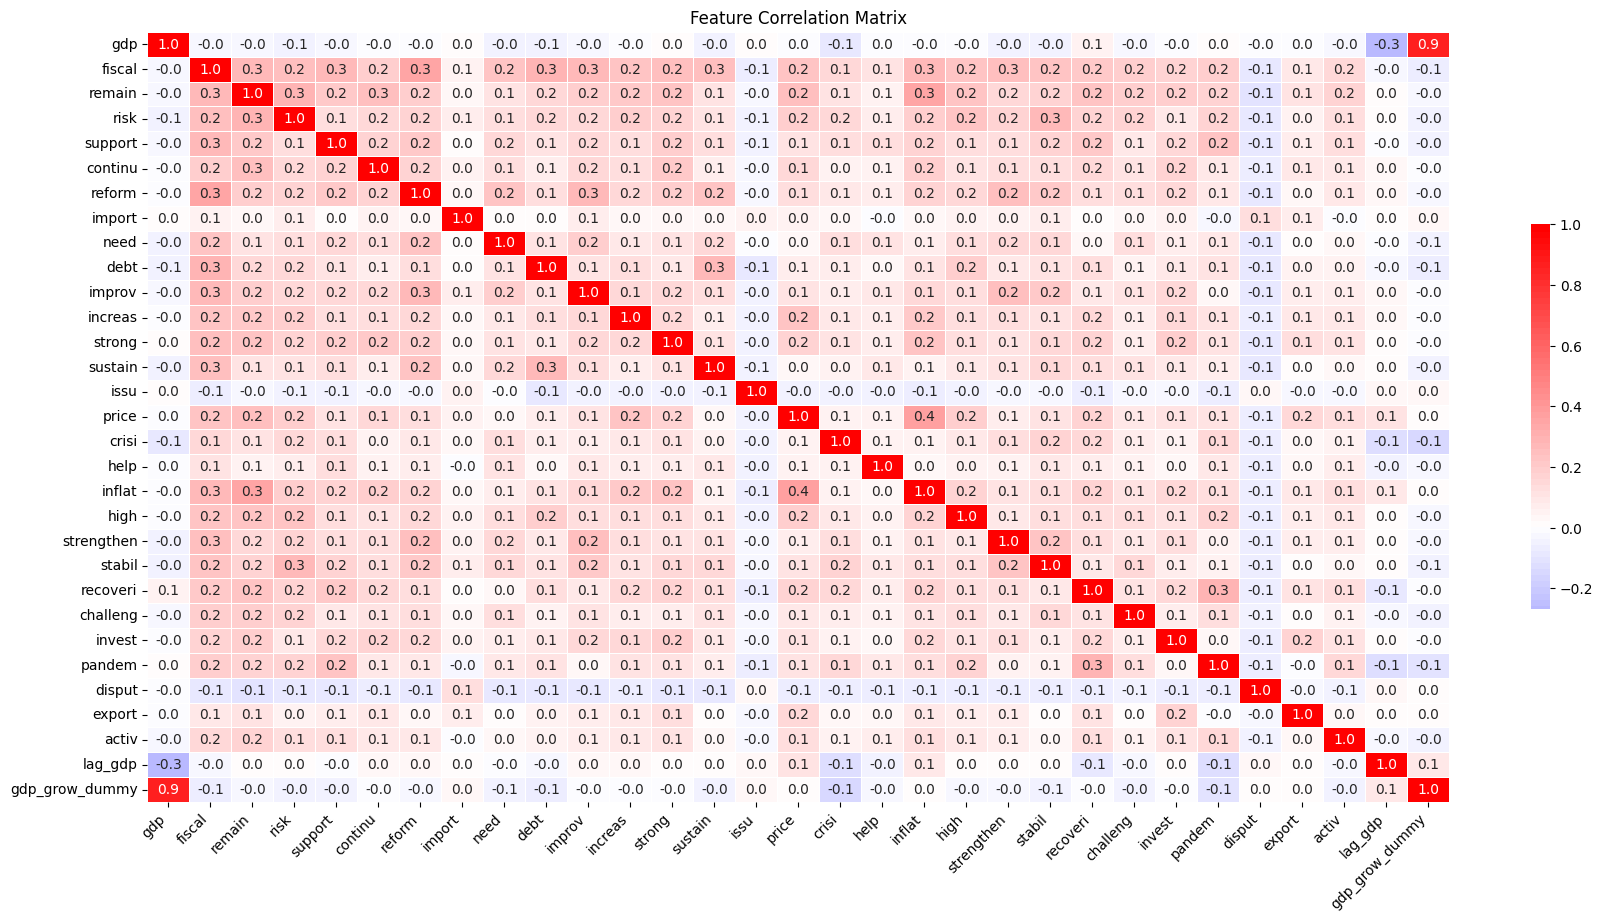

In [49]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
# Assuming 'features' is a list of the columns for which you want to measure correlation
features = ['gdp','fiscal', 'remain', 'risk', 'support', 'continu', 'reform', 'import',
    'need', 'debt', 'improv', 'increas', 'strong', 'sustain', 'issu', 'price',
    'crisi', 'help', 'inflat', 'high', 'strengthen', 'stabil', 'recoveri', 'challeng',
    'invest', 'pandem', 'disput', 'export', 'activ','lag_gdp','gdp_grow_dummy']
correlation_matrix = df[features].corr()


# Define a color map: Blue for negative, white for zero, red for positive
colors = ["blue", "white", "red"]  # Blue to white to red
n_bins = 100  # Use 100 bins in the colormap
cmap_name = "custom_diverging"

# Create the colormap
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Set up the matplotlib figure with your preferred dimensions
plt.figure(figsize=(21, 10))

# Draw the heatmap using the custom color scale
sns.heatmap(correlation_matrix, annot=True, fmt=".1f", cmap=cm,
            center=0, square=False, linewidths=.7, cbar_kws={"shrink": .5})

# Add title and labels as necessary
plt.title('Feature Correlation Matrix')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show plot
plt.show()



#### Top 5 Features mentioned each year.

In [50]:

features = [ 'fiscal', 'remain', 'risk', 'support', 'continu', 'reform', 'import',
    'need', 'debt', 'improv', 'increas', 'strong', 'sustain', 'issu', 'price',
    'crisi', 'help', 'inflat', 'high', 'strengthen', 'stabil', 'recoveri', 'challeng',
    'invest', 'pandem', 'disput', 'export', 'activ'
]

# Ensure 'Year' is a column and not an index, if it's an index reset it
if 'Year' not in df.columns:
    df.reset_index(inplace=True)

# Sum the feature dummy variables for each year
feature_sums_per_year = df.groupby('Year')[features].sum()

# Function to extract top 3 features and their counts for each year
def get_top_5_features(row):
    top_features = row.nlargest(5)
    return ', '.join([f"{feature} ({count})" for feature, count in top_features.items()])

# Apply the function to each year's data
top_5_features_per_year = feature_sums_per_year.apply(get_top_5_features, axis=1)
# Convert the Series into a DataFrame for better readability
top_5_features_per_year_df = top_5_features_per_year.to_frame(name='Top 5 Features')
top_5_features_per_year_df.reset_index(inplace=True)
# Print the DataFrame with the top 5 features listed for each year along with their counts
print(top_5_features_per_year_df)


         Year                                     Top 5 Features
0  2006-01-01  reform (37), fiscal (32), issu (30), need (29)...
1  2007-01-01  reform (46), continu (45), need (39), strong (...
2  2008-01-01  issu (58), fiscal (53), continu (51), strong (...
3  2009-01-01  crisi (69), fiscal (45), support (39), continu...
4  2010-01-01  crisi (74), fiscal (59), recoveri (48), need (...
5  2011-01-01  import (51), fiscal (46), crisi (45), need (42...
6  2012-01-01  disput (58), import (44), continu (30), issu (...
7  2013-01-01  issu (43), import (39), need (28), disput (28)...
8  2014-01-01  issu (44), import (42), help (37), support (29...
9  2015-01-01  issu (76), import (66), remain (63), support (...
10 2016-01-01  remain (77), risk (74), import (66), issu (61)...
11 2017-01-01  remain (94), continu (89), support (81), impor...
12 2018-01-01  remain (74), risk (53), continu (50), inflat (...
13 2019-01-01  fiscal (97), risk (83), remain (82), reform (8...
14 2020-01-01  pandem (82

In [51]:
import spacy

# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Function to extract countries or return "NA" if none are found
def extract_countries_or_na(text):
    doc = nlp(text)
    countries = [ent.text for ent in doc.ents if ent.label_ == 'GPE']
    return ', '.join(countries) if countries else "NA"

# Assuming 'Title' is a column in your DataFrame
df['country'] = df['Title'].apply(extract_countries_or_na)
df['country'] = df['country'].str.split(',').str[0]

# Filter out rows where 'country' is "NA"
df_filtered = df[df['country'] != "NA"]

# Count the occurrence of each country
count_countries = df_filtered['country'].value_counts()
# Print the unique country names and their counts, excluding "NA"
print(count_countries)
top_countries = df_filtered.sort_values('country', ascending=False).head(8)

country
US                                                                        146
China                                                                      97
Doha                                                                       57
India                                                                      57
Japan                                                                      55
                                                                         ... 
Tanzania                                                                    1
New York                                                                    1
Bangkok                                                                     1
Shanghai                                                                    1
the People's Republic of China-Hong Kong Special Administrative Region      1
Name: count, Length: 297, dtype: int64


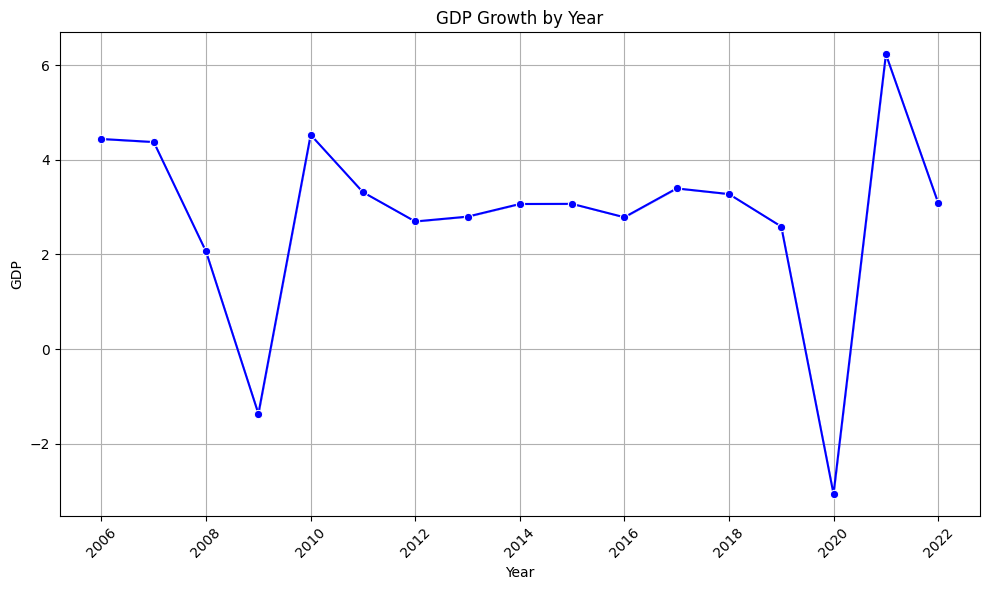

In [52]:
# Create a seaborn line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='gdp', data=df, marker='o', color='b', linestyle='-')
plt.title('GDP Growth by Year')
plt.xlabel('Year')
plt.ylabel('GDP')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

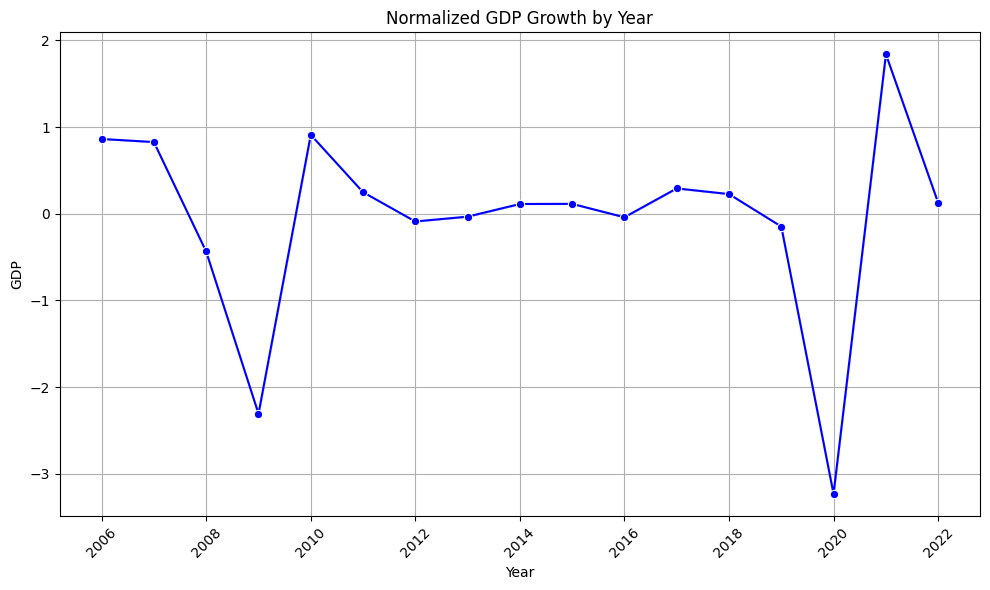

In [53]:
# Create a seaborn line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='gdp_normal', data=df, marker='o', color='b', linestyle='-')
plt.title('Normalized GDP Growth by Year')
plt.xlabel('Year')
plt.ylabel('GDP')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Summary

This notebook demonstrates the basic technologies of doing data analysis for different data types, including

  - Data overview (understanding column data types, values, and distributions)
  - Data cleaning (remove missing values, outlier detection)
  - Data transformation (normalization, tokenization, lemmatization)
  - Feature engineering (encoding categorical data, text feature representation)
  - Understanding the interactions between columns (colinearty examination)